In [9]:
import pandas as pd
import json as js
from glob import glob
import os
from main import make_parser
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
from configparser import ConfigParser

In [2]:
sns.set_theme(style='whitegrid')

In [3]:
dirs = glob('models/*')
dirs = [d for d in dirs if glob(d+'/*/*/*')]
print('Available hyperparam experiments:')
print(', '.join(dirs))

Available hyperparam experiments:
models/nabid_embed-dim, models/nabid_embed-dim_1, models/TP53_all_single, models/test_mil_tp53, models/nabid_sc_0, models/KRAS_all_single, models/cls_tp53_mil, models/nabid_sc_1, models/variant_nb_KRAS, models/nabid, models/cls_kras_mil, models/nabid_sc_2, models/experiment_test, models/TP53_siam_single, models/test, models/cls_tp53_mil_2norm, models/batch_tp53_mil_2norm, models/batch_tp53_0


In [6]:
path = 'models/variant_nb_KRAS/'
run_name = path.split('/')[-2]
run_name

'variant_nb_KRAS'

# Read records

In [30]:
parser = make_parser()
records = []
notfound = 0
for p in glob(path+'*'):
    name = os.path.basename(p)
    filename = os.path.join(p, 'best_score.json')
    try:
        with open(filename) as reader:
            d = js.load(reader)
    except FileNotFoundError:
        d = {}
        # print(p, ' Not found')
        notfound+=1
    cfg_path = os.path.join(p, 'config.ini')
    if os.path.exists(cfg_path):
        # load defaults
        cfg = vars(parser.parse_args(['.',name,]))
        d.update(cfg)
        # update from config file
        # CORRECTION OF BADLY FORMATTED CONFIG FILES : delete three last lines
        with open(os.path.join(p, 'config.ini'), 'r') as reader:
            lines = reader.readlines()
        if '[]\n' in lines:
            with open(os.path.join(p, 'config.ini'), 'w') as writer:
                writer.writelines(lines[:-3])
        with open(cfg_path) as reader:
            cfg = ConfigParser()
            cfg.read_file(reader)
        d.update(cfg['DEFAULT'])
        # print(d)
        
        records.append(d)
print(f'{notfound} runs not found')
results = pd.DataFrame.from_records(records)
results = results.drop(columns=['data_path','dest_name','verbose','restart', 'load_split','n_workers','overwrite','run_test','cpu', 'config_file', ])
results = results.drop(columns=['no_norm_embeds','group_synon', 'alpha'])
results = results.set_index('run_name').dropna(subset=['5_nn_ref_seen'])

284 runs not found


In [60]:
# Necessary bc configparser reads everything as string
for col in results.columns:
    if results[col].dtype == object:
        try:
            results[col] = results[col].astype(float)
        except ValueError:
            pass

In [78]:
## N variant experiment : not always relevant
# next time look in run_meta.json
exp_id = pd.Series(results.index.str.split('_').str[-1].astype(int), results.index)
# id = i*8*10+(j-1)*10+k
results['n_variants'] = 10* (exp_id %80 // 10 +1)
results['fold'] = exp_id//80
results.n_variants.value_counts()

n_variants
10    23
20    16
50    16
40    15
70    13
60    13
80    11
30     9
Name: count, dtype: int64

In [79]:
results['n_layers'] = results['shape'].apply(lambda x : len(x))
results['hid_dim'] = results['shape'].apply(lambda x : x[0])

In [80]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
root = 'runs/'+'/'.join(path.split('/')[1:])
records = []
# for file in glob(root+'/*'):
for file in glob('runs/variant_nb_KRAS_*'): ### ATTENTION : ad_hoc solution to erroneous save path. change back when fixed
    event_acc = EventAccumulator(file)
    event_acc.Reload()
    name = os.path.basename(file)
    for tag in event_acc.Tags()['scalars']:
        for event in event_acc.Scalars(tag):
            records.append({'run_name': name, 'tag': tag, 'step': event.step, 'value': event.value})
    
full_scores = pd.DataFrame.from_records(records).dropna()

In [81]:
full_scores

,run_name,tag,step,value
0,variant_nb_KRAS_112,train/5_nn_self,0,0.049080
1,variant_nb_KRAS_112,train/5_nn_self,1,0.064285
2,variant_nb_KRAS_112,train/5_nn_self,2,0.070882
3,variant_nb_KRAS_112,train/5_nn_self,3,0.078435
4,variant_nb_KRAS_112,train/5_nn_self,4,0.080810
...,...,...,...,...
484866,variant_nb_KRAS_90,test_unseen/5_nn_self,595,0.139358
484867,variant_nb_KRAS_90,test_unseen/5_nn_self,596,0.139146
484868,variant_nb_KRAS_90,test_unseen/5_nn_self,597,0.139358
484869,variant_nb_KRAS_90,test_unseen/5_nn_self,598,0.139411


In [82]:
max_scores = full_scores[full_scores.tag.str.contains('nn')].groupby(['run_name','tag'])['value'].max().reset_index()


In [83]:
min_losses = full_scores[full_scores.tag.str.contains('loss')].groupby(['run_name','tag'])['value'].min().reset_index()
best = pd.concat([max_scores, min_losses])
best = best.set_index('run_name').pivot(columns='tag', values='value')
best = best.merge(results, left_index=True, right_index=True)

# Results

In [84]:
best.sort_values('test_seen/5_nn_ref', ascending=False).head(20)

,test_seen/5_nn_ref,test_seen/5_nn_self,test_seen/loss,test_unseen/5_nn_self,train/5_nn_self,train/loss,5_nn_ref_seen,i,data_subset,unseen_frac,...,patience,cosine_t,task,knn,bag_size,mil_mode,n_variants,n_layers,hid_dim,fold
run_name,,,,,,,,,,,,,,,,,,,,,
variant_nb_KRAS_164,0.450704,0.411268,1.619463,0.143978,1.000000,0.713147,0.450704,41.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,2
variant_nb_KRAS_84,0.384088,0.337449,1.740587,0.146289,0.999695,0.757595,0.384088,116.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,1
variant_nb_KRAS_4,0.383234,0.354491,1.767426,0.123989,1.000000,0.626127,0.383234,369.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,0
variant_nb_KRAS_163,0.365217,0.320497,1.825947,0.145690,0.998344,0.648607,0.365217,73.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,2
variant_nb_KRAS_85,0.351706,0.314961,1.845152,0.148722,0.999126,0.655314,0.351706,9.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,1
variant_nb_KRAS_81,0.351385,0.302267,1.827569,0.142850,0.999160,0.679571,0.351385,53.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,1
variant_nb_KRAS_87,0.349515,0.351942,1.841395,0.148034,0.999460,0.626235,0.349515,71.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,1
variant_nb_KRAS_1,0.348783,0.315180,1.884172,0.132697,0.998197,0.638730,0.348783,366.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,0
variant_nb_KRAS_165,0.348750,0.321250,1.867909,0.137546,0.997500,0.667327,0.348750,46.0,processed,0.25,...,40,300.0,classifier,5,0,attention,10,15,[,2


## Plots

<Axes: xlabel='test_unseen/5_nn_self', ylabel='test_seen/5_nn_self'>

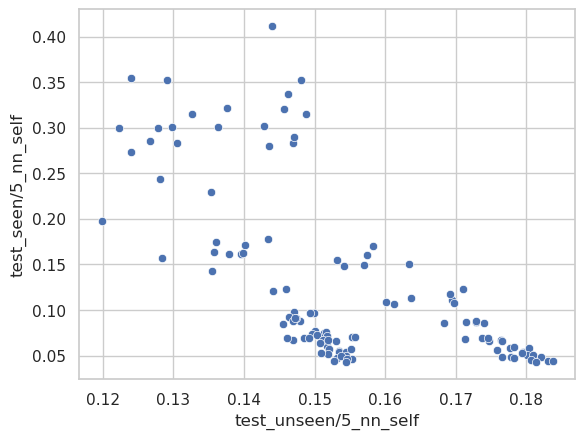

In [85]:
x = 'test_unseen/5_nn_self'
sns.scatterplot(best, x=x,y=best['test_seen/5_nn_self'],)
# plt.xscale('log')
# plt.savefig(f'plots/hparam/{run_name}_{x}_score.pdf')

In [86]:
ttest_ind(results[results['mil_mode']=='attention']['5_nn_ref_seen'], results[results['mil_mode']=='mean']['5_nn_ref_seen'], equal_var=False)

TtestResult(statistic=nan, pvalue=nan, df=nan)

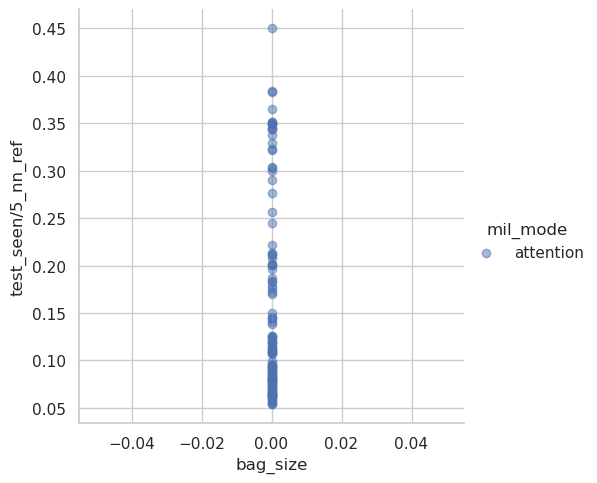

In [87]:
logscale = False

sns.lmplot(data=best,x='bag_size',y='test_seen/5_nn_ref' ,hue='mil_mode', scatter_kws={'alpha':0.5}, logx=logscale	)
if logscale:
    # plt.xlabel('$log_{10}$ ' + x.name)
    plt.xscale('log')
plt.savefig(f'plots/hparam/{run_name}_bag_size_score_reg.pdf')

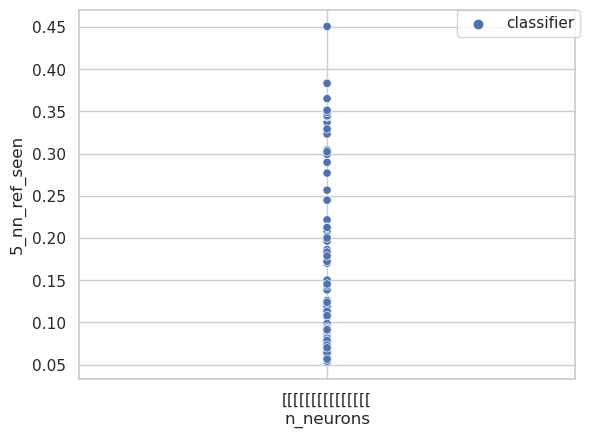

In [88]:
x = (results.n_layers * results.hid_dim).rename('n_neurons')
y = results['5_nn_ref_seen']
c = results.task

xlog = False
ylog = False
if xlog:
    x = np.log10(x)
if ylog : 
    y = np.log10(y)
sns.scatterplot(results, x=x,y=y, 
                # size=c,
                  hue=c )
if xlog:
    plt.xlabel('$log_{10}$ ' + x.name)
if ylog:
    plt.ylabel('$log_{10}$ ' + y.name)
# move the legend out of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

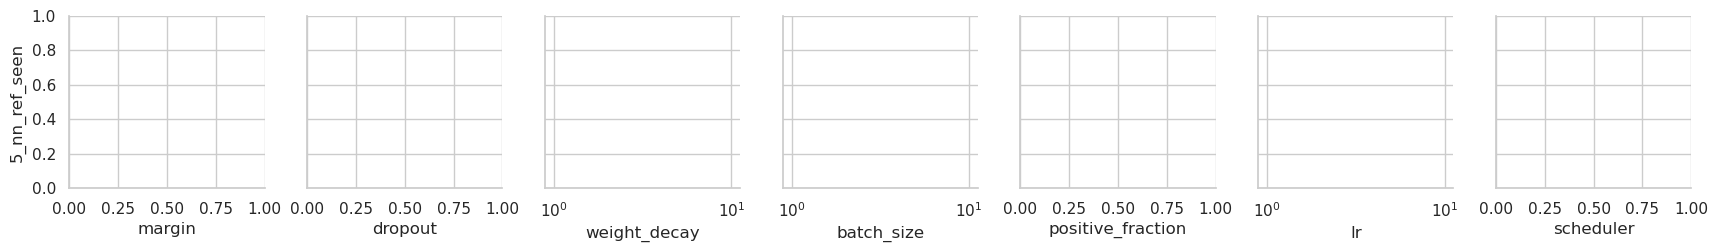

In [89]:
pp = sns.pairplot(results.dropna(),x_vars=['margin', 'dropout','weight_decay', 'batch_size', 'positive_fraction', 
       'lr', 'scheduler', ] , y_vars=['5_nn_ref_seen'] )
for ax in pp.axes.flat:
    if ax.get_xlabel() in ['weight_decay', 'batch_size','lr']:
        ax.set(xscale="log")

### self vs ref

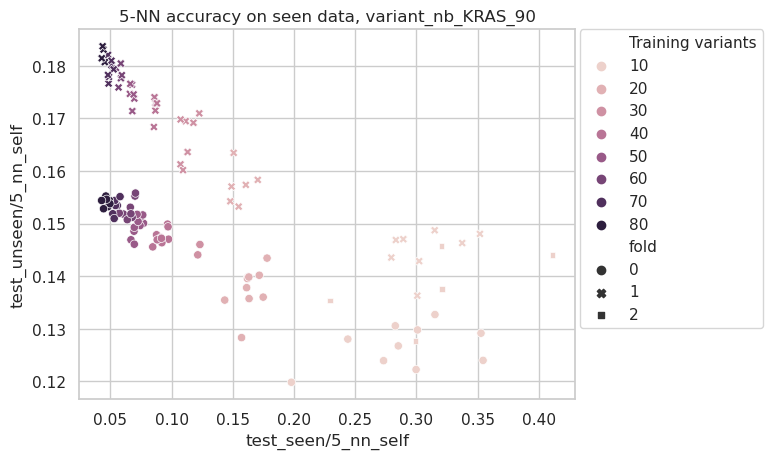

In [100]:
sns.scatterplot(x=best['test_seen/5_nn_ref'],y=best['test_unseen/5_nn_self'],hue=best['n_variants'].rename('Training variants'), style=best['fold'], legend='full')
plt.title(f'5-NN accuracy on seen data, {name}')
# legend outside bounds
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
# plt.savefig(f'plots/scores/score_ref_vs_self_{name}.pdf')

Text(0.5, 1.0, '5-NN accuracy on seen data, variant_nb_KRAS_90')

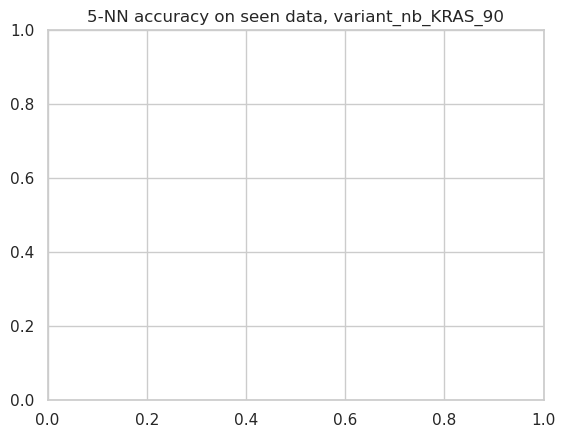

In [91]:
f = best['scheduler']=='plateau'
sns.scatterplot(
    x=best.loc[f,'test_seen/5_nn_ref'],
    y=best.loc[f,'test_seen/5_nn_self'],
    hue=best.loc[f,'cosine_t'])
plt.title(f'5-NN accuracy on seen data, {name}')

In [92]:
raise(RuntimeError('Stop here, the rest is model dependant'))

RuntimeError: Stop here, the rest is model dependant

### MIL implementation check (test_mil_tp53)

In [ ]:
ttest_ind(results[results['instance']==0]['5_nn_ref_seen'], results[results['instance']==1]['5_nn_ref_seen'], equal_var=False)

TtestResult(statistic=1.8517140305580166, pvalue=0.0690258747989238, df=59.55710370948449)

In [ ]:
s = results[results['instance']==0]['5_nn_ref_seen'].std()
p = TTestIndPower().power(effect_size = 2e-3/s, nobs1=results.index.size//2, alpha = 0.05, df=45)
p

0.9459528539821581

$\alpha > 0.05$ for average MIL on 1 sample vs no MIL (as it should be), power is 0.95 for a 0.002 difference in score, so 5% chance of missing a change this big.

## Missing values

In [ ]:
missing = results['5_nn_ref_seen'].isna()
results[missing]

,5_nn_ref_seen,i,loss,margin,dropout,weight_decay,batch_size,positive_fraction,shape,n_epochs,lr,scheduler,patience,cosine_t,task,knn,instance,mil_mode,n_layers,hid_dim
run_name,,,,,,,,,,,,,,,,,,,,


In [ ]:
results['missing'] = missing

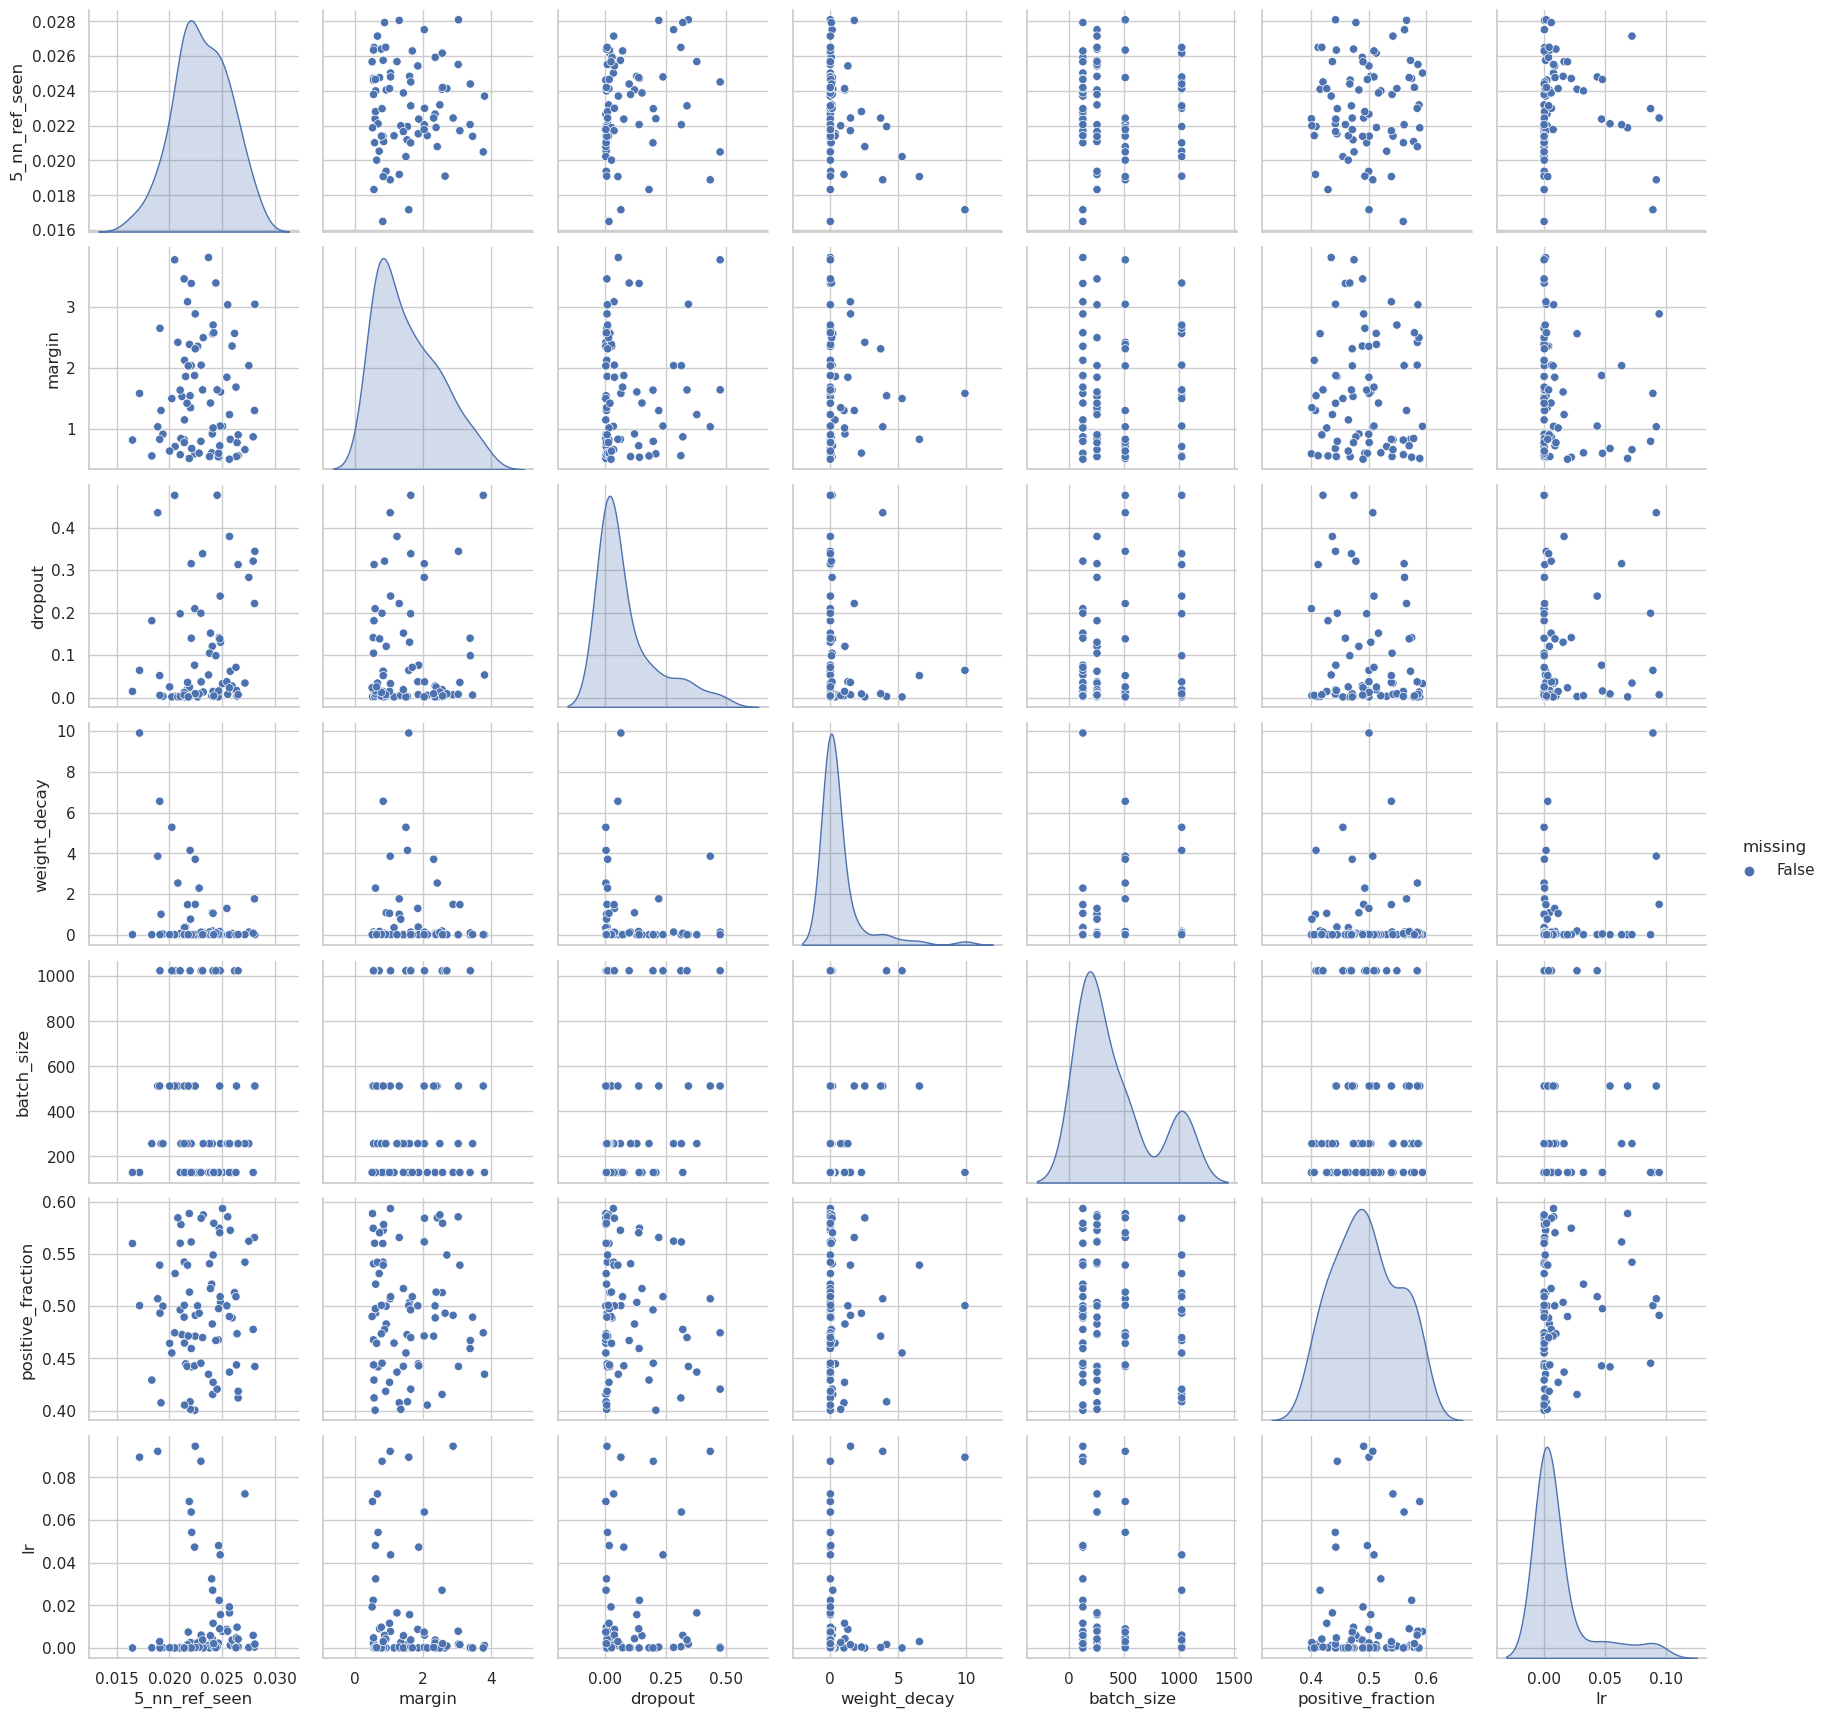

In [ ]:
sns.pairplot(results[['5_nn_ref_seen', 'margin', 'dropout','weight_decay', 'batch_size', 'positive_fraction', 
       'lr', 'scheduler', 'missing'] ], hue='missing')

## Late stopping models

In [ ]:
results[results.i > 500].sort_values('i', ascending=False).drop(columns=['loss','n_epochs'])

,5_nn_ref_seen,i,margin,dropout,weight_decay,batch_size,positive_fraction,shape,lr,scheduler,patience,cosine_t,task,knn,instance,mil_mode,n_layers,hid_dim,missing
run_name,,,,,,,,,,,,,,,,,,,
test_mil_tp53_52,0.024133,597,2.700510,0.008987,0.001446,1024,0.548889,"[491, 491, 491]",0.000910,restarts,489,594,classifier,5,0,mean,3,491,False
test_mil_tp53_47,0.021876,583,0.513365,0.001762,0.000277,512,0.588541,"[237, 237, 237]",0.068684,restarts,22,68,classifier,5,0,mean,3,237,False
test_mil_tp53_39,0.018888,566,1.032370,0.434789,3.858753,512,0.507032,"[250, 250, 250, 250]",0.092224,plateau,173,177,classifier,5,1,mean,4,250,False
test_mil_tp53_5,0.026505,551,0.900184,0.006799,0.008496,256,0.418522,"[357, 357, 357, 357]",0.004190,restarts,166,366,classifier,5,0,mean,4,357,False
test_mil_tp53_9,0.021895,542,2.383065,0.024675,0.016851,512,0.513377,"[139, 139]",0.000016,restarts,19,290,classifier,5,0,mean,2,139,False
test_mil_tp53_74,0.019198,532,1.299252,0.004460,1.004693,256,0.407490,"[444, 444]",0.000023,restarts,101,415,classifier,5,1,mean,2,444,False
test_mil_tp53_45,0.021386,511,3.457478,0.005880,0.007992,256,0.489417,"[442, 442]",0.000015,restarts,145,79,classifier,5,1,mean,2,442,False
test_mil_tp53_26,0.024763,506,0.721274,0.138172,0.159139,512,0.570167,"[213, 213]",0.008997,restarts,14,137,classifier,5,1,mean,2,213,False
test_mil_tp53_66,0.026499,503,0.558286,0.312885,0.006774,1024,0.412182,"[84, 84, 84, 84]",0.000577,restarts,201,189,classifier,5,0,mean,4,84,False
